# EMD_classifier

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm
from collections import Counter

## Data loading

In [2]:
events= pd.read_csv("/home/karla/Downloads/event_output_noFSI.txt", nrows=11,
                    names=["Event", "Enu", "Int", "ID", "Px", "Py", "Pz", "E", "M"], 
                     skiprows=1, sep='\s+')

In [3]:
events.head(50)

,Event,Enu,Int,ID,Px,Py,Pz,E,M
0,0,1.101,1,13,-0.49040,-0.1355,0.6946,0.8675,0.1057
1,0,1.101,1,2212,0.45870,0.2159,0.4136,1.1440,0.9383
2,1,3.568,3,13,-0.31840,0.4182,2.6220,2.6760,0.1057
3,1,3.568,3,2112,0.32130,-0.7487,0.5665,1.3670,0.9396
4,1,3.568,3,211,-0.07605,0.3942,0.1598,0.4541,0.1396
5,2,2.833,3,13,0.16820,-0.4763,2.0420,2.1060,0.1057
6,2,2.833,3,2212,-0.38980,0.2812,0.5929,1.2100,0.9383
7,2,2.833,3,211,0.08861,0.2842,0.2965,0.4428,0.1396
8,3,1.513,1,13,0.38590,-0.4373,0.5581,0.8141,0.1057
9,3,1.513,1,2212,-0.54990,0.3649,1.1270,1.6080,0.9383


## Separation by number of particles

In [4]:
# We need to take the total number of particles per event (2 or 3) and take px0 py0 pz0 M0 px1 py1 pz1 M1 Int(x1)
# for two particles and px0 py0 pz0 M0 px1 py1 pz1 M1 px2 py2 pz2 M2 Int(x1) for the case of 3 particles and then
# use the corresponding classifier for each case.

In [5]:
#pandas.Series.value_counts()

counter = Counter(events['Event'])
counter

Counter({0: 2, 1: 3, 2: 3, 3: 2, 4: 1})

In [6]:
def Counter(counter):
    events_2p = pd.DataFrame()
    events_3p = pd.DataFrame()
    
    for i in range(len(events['Event'])):
        index = events.index[events['Event']==i].tolist()
        if counter[i] == 2:
            events_2p = events_2p.append(events.loc[index], ignore_index=True)
    
        if counter[i] == 3:
            events_3p = events_3p.append(events.loc[index], ignore_index=True)
        
    
    return events_2p, events_3p        
    

In [7]:
events_2p, events_3p = Counter(counter)

In [8]:
events_3p

,Event,Enu,Int,ID,Px,Py,Pz,E,M
0,1,3.568,3,13,-0.31840,0.4182,2.6220,2.6760,0.1057
1,1,3.568,3,2112,0.32130,-0.7487,0.5665,1.3670,0.9396
2,1,3.568,3,211,-0.07605,0.3942,0.1598,0.4541,0.1396
3,2,2.833,3,13,0.16820,-0.4763,2.0420,2.1060,0.1057
4,2,2.833,3,2212,-0.38980,0.2812,0.5929,1.2100,0.9383
5,2,2.833,3,211,0.08861,0.2842,0.2965,0.4428,0.1396


## Data pre-processing 


In [4]:
train_events = events[["Px","Py", "Pz", "M"]].to_numpy()
train_labels = events ["Int"].to_numpy()

In [5]:
train, test = train_test_split(train_events, test_size=0.2, shuffle=False)
lab_te, lab_tr = train_test_split(train_labels, test_size=0.8, shuffle=False)
print(len(train))
print(len(lab_tr))
print(len(lab_te))
print(len(test))

80000
80000
20000
20000


In [6]:
class Data(Dataset):  
    def __init__(self, X_train, y_train):
        self.X = torch.from_numpy(X_train.astype(np.float32))
        #elf.y = torch.from_numpy(y_train)
        #self.y = torch.from_numpy(y_train.astype(np.float32))
        self.y = torch.from_numpy(y_train).type(torch.LongTensor)
        self.len = self.X.shape[0]
  
    def __getitem__(self, index):
        return self.X[index], self.y[index]  
    def __len__(self):
        return self.len

In [7]:
batch_size = 10000

traindata = Data(train,lab_tr)
trainloader = DataLoader(traindata, batch_size=batch_size, 
                         shuffle=True, num_workers = 2)

testdata = Data(test,lab_te)
testloader = DataLoader(testdata, batch_size=batch_size//10, 
                        shuffle=True, num_workers=2)

## Network and Training

In [8]:
# number of features (len of X cols)
input_dim = 4
# number of hidden layers
hidden_layers = 25
# number of classes (unique of y)
output_dim = 5 #(#dim+1)
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_layers)
        self.linear2 = nn.Linear(hidden_layers, hidden_layers )
        self.linear3 = nn.Linear(hidden_layers, output_dim)  
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [9]:
clf = Network()
criterion = nn.CrossEntropyLoss() #Softmax + CrossEntropy
optimizer = torch.optim.SGD(clf.parameters(), lr=0.1)

In [10]:
epochs = 100
losses=[]
#for epoch in tqdm(range(epochs)):
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # set optimizer to zero grad to remove previous epoch gradients
        optimizer.zero_grad()
        # forward propagation
        outputs = clf(inputs)
        loss = criterion(outputs, labels)
        # backward propagation
        loss.backward()
        # optimize
        optimizer.step()
        running_loss += loss.item()
    losses.append(loss.item())
    print(f'Epoch {epoch + 1} ============== > loss: {running_loss:.5f}')

Epoch 1 ============== > loss: 11.22491
Epoch 2 ============== > loss: 9.93116
Epoch 3 ============== > loss: 9.59259
Epoch 4 ============== > loss: 9.47195
Epoch 5 ============== > loss: 9.41068
Epoch 6 ============== > loss: 9.37511
Epoch 7 ============== > loss: 9.35218
Epoch 8 ============== > loss: 9.33621
Epoch 9 ============== > loss: 9.32433
Epoch 10 ============== > loss: 9.31510
Epoch 11 ============== > loss: 9.30791
Epoch 12 ============== > loss: 9.30172
Epoch 13 ============== > loss: 9.29687
Epoch 14 ============== > loss: 9.29266
Epoch 15 ============== > loss: 9.28933
Epoch 16 ============== > loss: 9.28644
Epoch 17 ============== > loss: 9.28367
Epoch 18 ============== > loss: 9.28146
Epoch 19 ============== > loss: 9.27963
Epoch 20 ============== > loss: 9.27800
Epoch 21 ============== > loss: 9.27659
Epoch 22 ============== > loss: 9.27537
Epoch 23 ============== > loss: 9.27455
Epoch 24 ============== > loss: 9.27337
Epoch 25 ============== > loss: 9.27262
Epoch 26

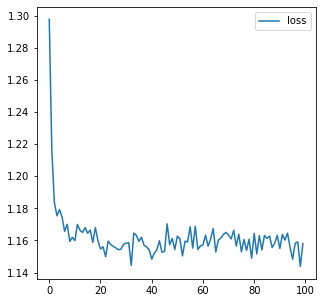

In [11]:
# Plot loss
plt.figure(figsize=(5, 5))
plt.plot(losses, label='loss')
plt.legend()
plt.show()

## Testing

In [12]:
correct, total = 0, 0
# no need to calculate gradients during inference
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        # calculate output by running through the network
        outputs = clf(inputs)
        # get the predictions
        __, predicted = torch.max(outputs.data, 1)
        # update results
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the {len(testdata)} test data: {100 * correct // total} %')



Accuracy of the network on the 20000 test data: 44 %


In [13]:
dataiter = iter(testloader)
inputs, labels = next(dataiter)
print(inputs.shape)
print(labels)

torch.Size([1000, 4])
tensor([2, 3, 1, 4, 3, 4, 4, 3, 2, 3, 1, 4, 3, 4, 4, 3, 1, 2, 3, 3, 3, 4, 3, 4,
        3, 1, 3, 1, 1, 4, 4, 4, 4, 3, 1, 1, 4, 1, 3, 3, 4, 3, 4, 3, 2, 3, 4, 4,
        4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 2, 3, 4, 4, 3, 2, 4, 4, 4,
        4, 1, 4, 1, 4, 3, 4, 1, 4, 3, 3, 2, 4, 4, 3, 3, 4, 4, 3, 4, 1, 1, 4, 1,
        4, 1, 3, 4, 3, 4, 3, 1, 4, 3, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 4, 3, 3, 2,
        4, 1, 4, 3, 4, 4, 1, 4, 3, 1, 4, 1, 3, 0, 4, 4, 4, 3, 3, 1, 4, 4, 3, 4,
        3, 3, 1, 1, 4, 4, 3, 3, 3, 4, 3, 4, 4, 3, 4, 3, 3, 4, 3, 4, 4, 3, 3, 4,
        3, 1, 4, 4, 4, 4, 1, 3, 3, 4, 3, 4, 3, 4, 4, 4, 3, 4, 1, 3, 1, 4, 3, 4,
        1, 3, 3, 4, 3, 2, 3, 4, 4, 3, 3, 4, 3, 3, 3, 3, 4, 1, 3, 4, 3, 4, 4, 2,
        4, 4, 4, 4, 3, 2, 4, 4, 3, 4, 2, 4, 3, 1, 4, 4, 4, 3, 3, 4, 4, 4, 1, 4,
        4, 3, 4, 3, 3, 3, 1, 4, 3, 4, 4, 4, 3, 3, 2, 4, 4, 4, 3, 1, 1, 1, 2, 4,
        4, 1, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 4, 3, 1, 4, 3, 1,
        3, 3, 4, 4

In [14]:
outputs = clf(inputs)
__, predicted = torch.max(outputs, 1)
print(predicted)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,